# Congruent number classification and prediction using Frobenius traces


The notebook contains ML experiments to classify and predict congruent numnbers. We use Frobenius traces at first $1000$ primes as features. The following ML models are used

- logistic regression,
- random forest,
- gradient boost,
- XGboost,
- descision tree classifier.


In [16]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix


# === Load data ===
#csv_file = 'cn_frobs.csv'  # Change to your filename
#df = pd.read_csv(csv_file)
table = pq.read_table("frobenius_cn1k.parquet")
df = table.to_pandas()
df


,n,iscongruent,a1,a2,a3,a4,a5,a6,a7,a8,...,a991,a992,a993,a994,a995,a996,a997,a998,a999,a1000
0,1,0,0,0,-2,0,0,6,2,0,...,-158,134,0,114,-98,0,0,-170,0,0
1,2,0,0,0,2,0,0,-6,2,0,...,-158,-134,0,114,98,0,0,170,0,0
2,3,0,0,0,2,0,0,6,-2,0,...,158,-134,0,114,98,0,0,170,0,0
3,5,1,0,0,0,0,0,-6,-2,0,...,-158,-134,0,-114,98,0,0,-170,0,0
4,6,1,0,0,-2,0,0,-6,-2,0,...,158,134,0,114,-98,0,0,-170,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607921,999991,1,0,0,-2,0,0,-6,0,0,...,158,134,0,-114,98,0,0,170,0,0
607922,999993,0,0,0,2,0,0,-6,2,0,...,-158,134,0,114,98,0,0,170,0,0
607923,999994,0,0,0,-2,0,0,-6,-2,0,...,158,134,0,114,98,0,0,170,0,0
607924,999995,0,0,0,0,0,0,6,2,0,...,-158,-134,0,-114,-98,0,0,-170,0,0


In [18]:
#df = df1[df1['n'] < 50000]
len_0 = min(df[df['iscongruent'] == 0].shape[0], 70000)
df_balanced = df[df['iscongruent'] == 1].sample(len_0) 
df_balanced1 = df[df['iscongruent'] == 0].sample(len_0) 
df_balanced = pd.concat([df_balanced, df_balanced1])
print(df_balanced.iscongruent.value_counts())


# === Features and target ===
#feature_cols = [f'a{i}' for i in range(1, 26)]
X = df_balanced.drop(columns=['iscongruent', 'n'])
y = df_balanced['iscongruent']

iscongruent
1    70000
0    70000
Name: count, dtype: int64


In [19]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# === Models to train ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'DTC': DecisionTreeClassifier()
}


Logistic Regression
Accuracy:  0.5144
Precision: 0.5144
Recall:    0.5124
F1 Score:  0.5134
ROC AUC:   0.5197


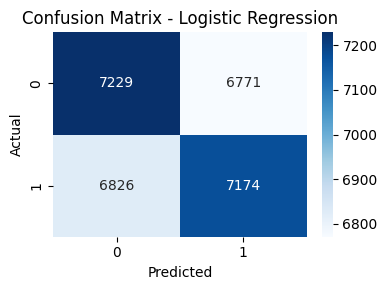


Random Forest
Accuracy:  0.5007
Precision: 0.5008
Recall:    0.4606
F1 Score:  0.4799
ROC AUC:   0.4999


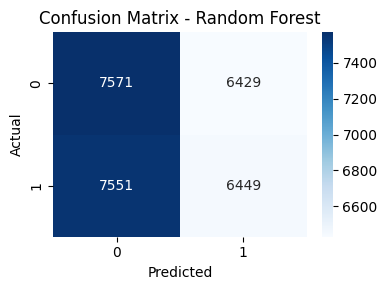


Gradient Boosting
Accuracy:  0.5169
Precision: 0.5177
Recall:    0.4941
F1 Score:  0.5056
ROC AUC:   0.5208


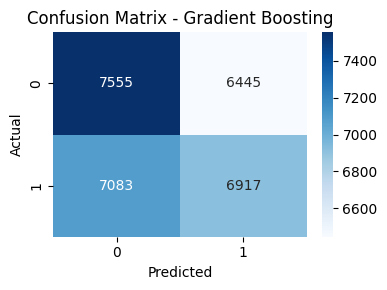


XGBoost
Accuracy:  0.4982
Precision: 0.4982
Recall:    0.5029
F1 Score:  0.5005
ROC AUC:   0.4962


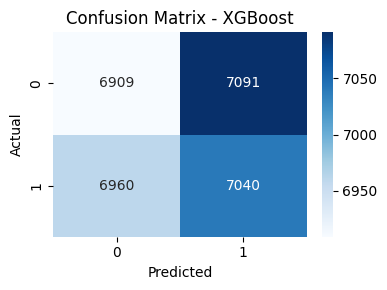


DTC
Accuracy:  0.4990
Precision: 0.4990
Recall:    0.5010
F1 Score:  0.5000
ROC AUC:   0.4990


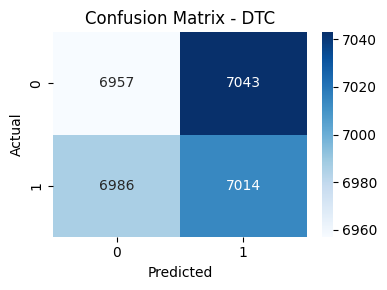

In [21]:
# === Train and evaluate ===
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # needed for ROC AUC

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [22]:
filtered_df = df.loc[:, df.iloc[0] != 0]
filtered_df.loc[:,'iscongruent'] = df['iscongruent']
filtered_df

/tmp/ipykernel_1695070/333889937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'iscongruent'] = df['iscongruent']


,n,a3,a6,a7,a10,a12,a13,a16,a18,a21,...,a986,a987,a988,a990,a991,a992,a994,a995,a998,iscongruent
0,1,-2,6,2,-10,-2,10,14,-10,-6,...,166,-14,122,-146,-158,134,114,-98,-170,0
1,2,2,-6,2,10,2,10,-14,10,-6,...,-166,-14,122,146,-158,-134,114,98,170,0
2,3,2,6,-2,10,-2,-10,-14,-10,-6,...,166,14,-122,146,158,-134,114,98,170,0
3,5,0,-6,-2,-10,2,10,-14,-10,6,...,166,14,-122,-146,-158,-134,-114,98,-170,1
4,6,-2,-6,-2,-10,2,-10,14,10,-6,...,-166,14,-122,-146,158,134,114,-98,-170,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607921,999991,-2,-6,0,-10,2,10,14,10,-6,...,-166,-14,-122,-146,158,134,-114,98,170,1
607922,999993,2,-6,2,10,2,-10,14,-10,6,...,166,14,122,146,-158,134,114,98,170,0
607923,999994,-2,-6,-2,-10,2,10,14,10,6,...,-166,14,122,146,158,134,114,98,170,0
607924,999995,0,6,2,10,-2,10,14,-10,-6,...,166,-14,122,-146,-158,-134,-114,-98,-170,0


In [12]:
filtered_df = filtered_df.rename(columns={'iscongrunet': 'iscongruent'})

len_0 = min(filtered_df[filtered_df['iscongruent'] == 0].shape[0], 70000)
df_balanced = filtered_df[filtered_df['iscongruent'] == 1].sample(len_0) 
df_balanced1 = filtered_df[filtered_df['iscongruent'] == 0].sample(len_0) 
df_balanced = pd.concat([df_balanced, df_balanced1])
print(df_balanced.iscongruent.value_counts())


# === Features and target ===
#feature_cols = [f'a{i}' for i in range(1, 26)]
X = df_balanced.drop(columns=['iscongruent'])
y = df_balanced['iscongruent']

iscongruent
1    70000
0    70000
Name: count, dtype: int64


In [13]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
# === Models to train ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'DTC': DecisionTreeClassifier()
}


Logistic Regression
Accuracy:  0.5272
Precision: 0.5273
Recall:    0.5259
F1 Score:  0.5266
ROC AUC:   0.5337


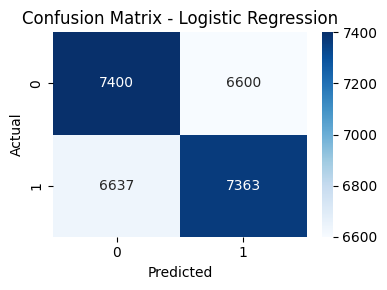


Random Forest
Accuracy:  0.4961
Precision: 0.4958
Recall:    0.4570
F1 Score:  0.4756
ROC AUC:   0.4932


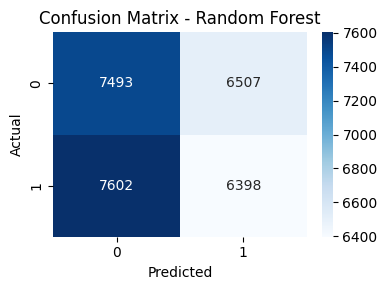


Gradient Boosting
Accuracy:  0.5231
Precision: 0.5242
Recall:    0.5003
F1 Score:  0.5120
ROC AUC:   0.5309


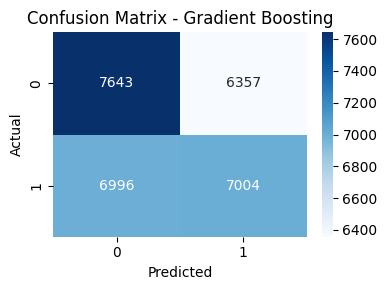


XGBoost
Accuracy:  0.5070
Precision: 0.5071
Recall:    0.5032
F1 Score:  0.5051
ROC AUC:   0.5116


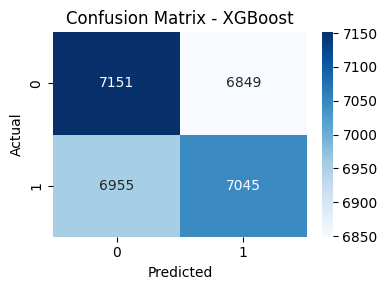


DTC
Accuracy:  0.4993
Precision: 0.4993
Recall:    0.4999
F1 Score:  0.4996
ROC AUC:   0.4993


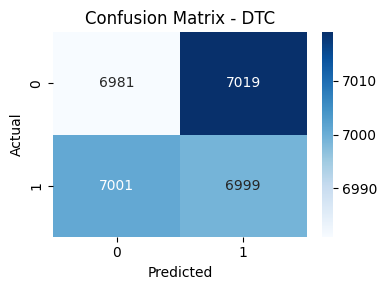

In [15]:
# === Train and evaluate ===
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # needed for ROC AUC

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()